In [1]:
import os
import random
import shutil

from shutil import copyfile

In [2]:

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = VALIDATION_DIR

In [3]:

# remove directory

for i in ['train', 'test']:
    shutil.rmtree(f'./{i}')

In [4]:
# create directory

label = ['cardboard', 'metal', 'paper', 'plastic']

root_path = './'

# for i in ['train', 'test']:
#     os.makedirs(os.path.join(f'{root_path}', i))
#     for j in label:
#         os.makedirs(os.path.join(f'{root_path}' + i, j))


# simpler code
for i in ['train', 'test']:
    os.makedirs(f'./{i}')
    for j in label:
        os.makedirs(f'./{i}/{j}')

In [5]:
split_size = .9

for i in label:
    # split_data('./dataset-sampah/' + i, './train/' + i, './test/' + i, split_size)

    # again, simpler code
    split_data(f'./dataset-sampah/{i}', f'./train/{i}', f'./test/{i}', split_size)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = './train/',
                                                      batch_size = 8,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = './test/',
                                                                batch_size = 8,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))

  return train_generator, validation_generator

In [7]:
train_generator, validation_generator = train_val_generators('./train/', './test/')

Found 1698 images belonging to 4 classes.
Found 191 images belonging to 4 classes.


In [40]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # __ classes
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 82944)             0         
                                                                 
 dense_15 (Dense)            (None, 256)              

In [9]:
from keras.callbacks import Callback

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.9 and logs.get('accuracy') > 0.9:
            self.model.stop_training = True

In [10]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=1000,
                    batch_size=50,
                    validation_data=validation_generator,
                    callbacks = MyCallback())

Epoch 1/1000
213/213 [==============================] - 22s 77ms/step - loss: 1.3742 - accuracy: 0.3115 - val_loss: 1.3985 - val_accuracy: 0.2147
Epoch 2/1000
213/213 [==============================] - 8s 37ms/step - loss: 1.3516 - accuracy: 0.3227 - val_loss: 1.3164 - val_accuracy: 0.3770
Epoch 3/1000
213/213 [==============================] - 8s 36ms/step - loss: 1.2784 - accuracy: 0.4016 - val_loss: 1.2610 - val_accuracy: 0.3717
Epoch 4/1000
213/213 [==============================] - 8s 35ms/step - loss: 1.2423 - accuracy: 0.4211 - val_loss: 1.2304 - val_accuracy: 0.4450
Epoch 5/1000
213/213 [==============================] - 8s 36ms/step - loss: 1.1916 - accuracy: 0.4488 - val_loss: 1.3214 - val_accuracy: 0.4503
Epoch 6/1000
213/213 [==============================] - 8s 36ms/step - loss: 1.1706 - accuracy: 0.4711 - val_loss: 1.1561 - val_accuracy: 0.4241
Epoch 7/1000
213/213 [==============================] - 8s 36ms/step - loss: 1.1069 - accuracy: 0.5230 - val_loss: 1.1079 - val_a

In [11]:
model.save('object-classification.h5')

In [41]:
model.load_weights('./object-classification.h5')

In [46]:
import cv2

img_test = []

img_test.append(cv2.imread('dataset-sampah\metal\metal18.jpg'))

for i in range(len(img_test)):
    img_test[i] = cv2.resize(img_test[i], (150,150))/255

In [47]:
import numpy as np

img_test = np.asarray(img_test)

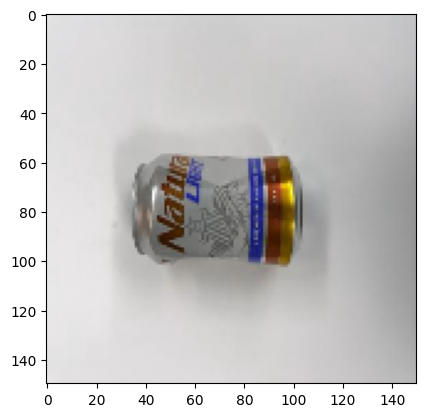

In [48]:
from matplotlib import pyplot as plt 

plt.imshow(img_test[0])

In [49]:
np.argmax(model.predict(img_test))

1/1 [==============================] - 0s 23ms/step


3

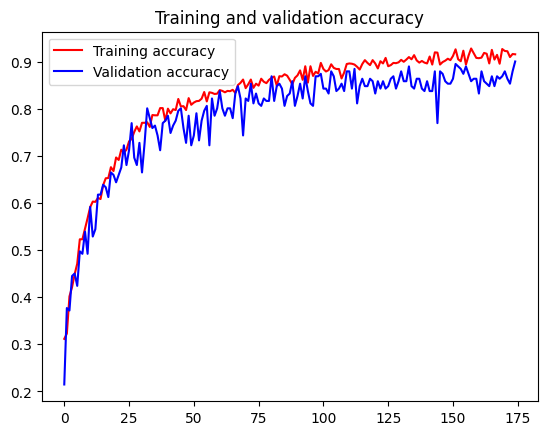

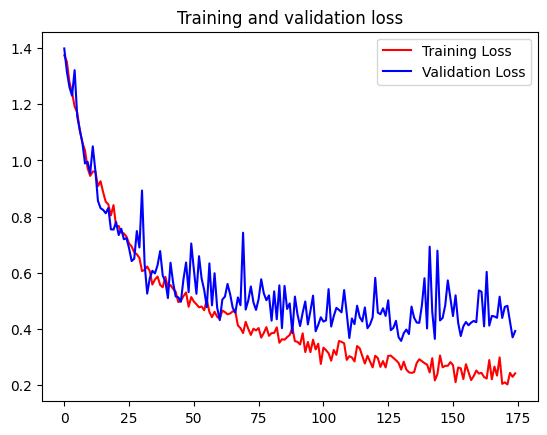

In [16]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()